# Author: Joshua Warner
This is my XGBoost algorithm to predict sales prices of homes in Ames, Iowa.


## Kaggle: House Prices: Advanced Regression Techniques
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import io
import requests
import matplotlib.pyplot as plt

#Importing test data
url_test = 'https://raw.githubusercontent.com/WepsDrawn/Machine-Learning-Projects/master/House%20Prices%3A%20Advanced%20Regression%20Techniques/test.csv'
get_test = requests.get(url_test).content
test = pd.read_csv(io.StringIO(get_test.decode('utf-8')))

#Importing training data
url_train = 'https://raw.githubusercontent.com/WepsDrawn/Machine-Learning-Projects/master/House%20Prices%3A%20Advanced%20Regression%20Techniques/train.csv'
get_train = requests.get(url_train).content
data = pd.read_csv(io.StringIO(get_train.decode('utf-8')))

#Looking at the data
print(data.keys())
print(data.shape)
print(test.keys())
print(test.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Cleaning data:
Visual outliers and columns with very litte data are removed. Wrongly labeled columns are replaced with a string data type. The data is separated into predictors and target variables.

In [88]:
#Removing found outliers from EDA and using a logarithmic
#fix on the sale price. Also removing high null value columns and an Id column.
data = data.drop([523,1298,691,1182],axis=0)
data = data.drop(['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],axis=1)
test = test.drop(['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],axis=1)

#Changing data type to categorical.
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

#Seperate the target data.
X, y = data.iloc[:,:-1], data.iloc[:,-1]

### Exploratory Data Analysis
With outliers removed, the data is easily seen to contain a curvature.

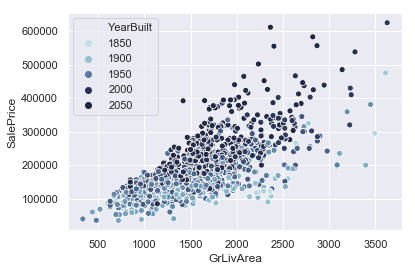

In [89]:
#Data Visualization EDA
sns.set()
cmap = sns.cubehelix_palette(rot=-.2,as_cmap=True)
ax = sns.scatterplot(x=X['GrLivArea'],y=y,hue=X['YearBuilt'],
                     palette=cmap,sizes=(10,200))
plt.show()

### Logarithmic Fix
By taking the natural log of the target value, the curve is corrected and the predictors will be more accurate.

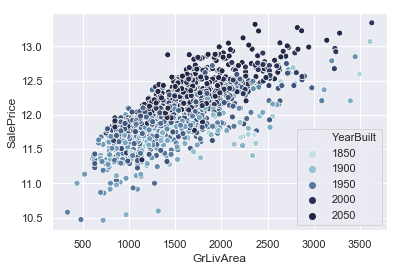

In [90]:
#Take the natural log of the y-value.
y = np.log1p(y)  
sns.set()
cmap = sns.cubehelix_palette(rot=-.2,as_cmap=True)
ax = sns.scatterplot(x=X['GrLivArea'],y=y,hue=X['YearBuilt'],
                     palette=cmap,sizes=(10,200))
plt.show()

## Fixing missing values correctly:
Fill missing values with different strategies depending on what best fits the data.

In [91]:
#Filling null values with appropriate values.
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X[i] = X[i].fillna(0)
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    X[i] = X[i].fillna('None')
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X[i] = X[i].fillna('None')
X['LotFrontage'] = X['LotFrontage'].fillna(X['LotFrontage'].median())
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X['MasVnrType'] = X['MasVnrType'].fillna('None')
X['Electrical'] = X['Electrical'].fillna("SBrkr")

for i in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[i] = test[i].fillna(0)
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    test[i] = test[i].fillna('None')
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[i] = test[i].fillna('None')
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['Electrical'] = test['Electrical'].fillna("SBrkr")

### Simplified Column
Found this idea by searching kernels,this code was firstly created by [ods.ai] Alex Lekov, I changed some values and it works well.

In [92]:
#Combining like columns.
X['Bathrooms'] = (X['FullBath'] + (0.1 * X['HalfBath']) + X['BsmtFullBath'] + (0.1 * X['BsmtHalfBath']))
test['Bathrooms'] = (test['FullBath'] + (0.1 * test['HalfBath']) + test['BsmtFullBath'] + (0.1 * test['BsmtHalfBath']))
X['SquareFootage']=X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['BsmtFinSF1'] + X['BsmtFinSF2']
test['SquareFootage']=test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF'] + test['BsmtFinSF1'] + test['BsmtFinSF2']
X['PorchFootage'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
test['PorchFootage'] = (test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch'] + test['ScreenPorch'] + test['WoodDeckSF'])

Check for any more null values.

In [93]:
#To clean up missing values.
nulls_per_column = X.isnull().sum()
print(nulls_per_column)

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
                ..
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea    

##  XGBoost Pipeline:
A pipeline is created to start fitting the training data. A vectorizer to utilize the dummy variables. A robust scaler is then used to help take deflate outlies and normalize the data. Then an extreme gradient boost regressor is used to predict the target values for the test data.

In [94]:
#Create a pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
pl = Pipeline([('vectorizer',DictVectorizer(sparse=False)),
               ('scaler',RobustScaler(with_centering=True)),
               ('XGBoost',xgb.XGBRegressor(objective="reg:linear",n_estimators=1000,max_depth=2,reg_alpha=.2,learning_rate=.1))])

### Change to dictionary
Change the predictor values to dictionaries so as to be used by the DictVectorizer.

In [95]:
#Change to a dictionary so as to be used in pipeline.    
X = X.to_dict('records')
test = test.to_dict('records')

### Take metrics
Cross validation scores are then used with a fold of 5. The scoring metric is the negative mean squared error. The absolute value of the 5 scores is taken. The square root function is now applied and then the mean of the 5 scores is taken and printed.

In [96]:
#Metrics.
cv_results = cross_val_score(pl,X,y,scoring='neg_mean_squared_error',cv=5)
print('The root mean square is ' + str(np.mean(np.sqrt(np.abs(cv_results)))))

The root mean square is 0.11294166205784435


## Fit the data and predict
The X predictors are fitted to the pipeline along with a y target values. The test predictors is then used to predict the sales prices for houses sold in Ames. Afterwards, since a logarithmic function was used, math.exp() function is used to make the values understandable.

In [97]:
pl.fit(X,y)
y_preds = pl.predict(test)

#Remove logarithmic fix.
for i in range(len(y_preds)):
    y_preds[i] = math.exp(y_preds[i])

## Submission:
The predictions are taken and put into a dataframe with their proper Id attached.

In [98]:
submission = pd.DataFrame({'Id':np.array(range(1461,2920)),'SalePrice':y_preds})

In [100]:
print(submission.head(30))

      Id      SalePrice
0   1461  126152.390625
1   1462  160420.953125
2   1463  189048.218750
3   1464  199097.609375
4   1465  181717.843750
5   1466  175205.234375
6   1467  180369.906250
7   1468  163148.890625
8   1469  186513.359375
9   1470  124871.281250
10  1471  198366.234375
11  1472   93485.921875
12  1473   95675.226562
13  1474  152420.390625
14  1475  119464.093750
15  1476  392257.937500
16  1477  253365.843750
17  1478  284834.000000
18  1479  260219.859375
19  1480  520407.218750
20  1481  351639.531250
21  1482  211455.984375
22  1483  167212.140625
23  1484  163086.828125
24  1485  181470.531250
25  1486  193006.250000
26  1487  345459.656250
27  1488  245750.062500
28  1489  201546.359375
29  1490  226267.343750
